# Import dataset

In [1]:
import pandas as pd
import json
import numpy as np 
import matplotlib.pyplot as plt
from transformers import set_seed 
import nlpaug.augmenter.word as naw 
# set width for dataframe display
pd.set_option('display.max_colwidth', 200)
# dataset_url = "https://git.io/nlp-with-transformers"
# df_issues = pd.read_json(dataset_url, lines=True)
# print(f"DataFrame shape: {df_issues.shape}")

## Load data from json file

In [2]:
df_issues = pd.read_json("dataset.json", lines=True)

In [3]:
df_issues.shape

(9930, 26)

In [4]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()


,2
url,https://api.github.com/repos/huggingface/transformers/issues/11044
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting started and issues
user,"{'login': 'stas00', 'id': 10676103, 'node_id': 'MDQ6VXNlcjEwNjc2MTAz', 'avatar_url': 'https://avatars.githubusercontent.com/u/10676103?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1', 'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed', 'name': 'DeepSpeed', 'color': '4D34F7', 'default': False..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated into HF `transformers`. \r\n\r\nWhile I tried to write tests for a ..."


In [5]:
# print all the columns
print(df_issues.columns)

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'performed_via_github_app',
       'pull_request'],
      dtype='object')


## Process label

In [6]:
df_issues["labels"] = (df_issues["labels"]
 .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [7]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}") 
df_counts.head(10).to_frame().T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
count,2284,649,106,98,64,52,50,46,42,41


In [8]:
label_map = {"Core: Tokenization": "tokenization",
 "New model": "new model",
 "Core: Modeling": "model training",
 "Usage": "usage",
 "Core: Pipeline": "pipeline",
 "TensorFlow": "tensorflow or tf",
 "PyTorch": "pytorch",
 "Examples": "examples",
 "Documentation": "documentation"}

In [9]:
def filter_lables(x): 
    return [label_map[label] for label in x if label in label_map] 
df_issues["labels"] = df_issues["labels"].apply(filter_lables) 
all_labels = list(label_map.values()) 

In [10]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.head(10).to_frame().T

Number of labels: 9


labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


## save the unlabels data

In [11]:
df_issues["split"] = "unlabeled"
mark = df_issues["labels"].apply(lambda x: len(x) > 0)
df_issues.loc[mark, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [12]:
# print some examples
for colume in ['title', 'body', 'labels']:
    print(f"{colume}: {df_issues[colume].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [13]:
# concat the title and body 
df_issues['text'] = (df_issues
                     .apply(lambda x: f"{x['title']} +  {x['body']}", axis=1))

In [14]:
df_issues['text'].head()

0    Potential incorrect application of layer norm in BlenderbotSmallDecoder +  In BlenderbotSmallDecoder,  layer norm is applied only on the token embeddings, and not on the hidden_states, whereas in ...
1    Multi-GPU seq2seq example evaluation significantly slower than legacy example evaluation +  \r\n### Who can help\r\n@patil-suraj @sgugger \r\n\r\nModels:\r\nT5\r\n\r\n## Information\r\n\r\nI've be...
2    [DeepSpeed] ZeRO stage 3 integration: getting started and issues +  **[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated...
3    Can't load model to estimater +  I was trying to follow the Sagemaker instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) to load the model I just trained and te...
4    [LXMERT] Unclear what img_tensorize does with color spaces +  ## Environment info\r\n\r\n- `transformers` version: Not using transformers directly, I'm loading a model "unc-nl

In [15]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset=['text'])
print(f"Remove {(len_before - len(df_issues)) / len_before:.2%} duplicates.")


Remove 1.88% duplicates.


## Plot the dataset

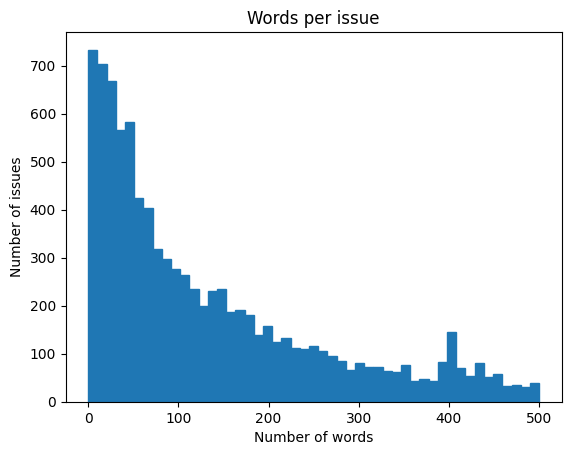

In [16]:
df_issues['text'].str.split().apply(len).hist(bins = np.linspace(0, 500, 50), grid=False, edgecolor='C0') 
plt.title("Words per issue") 
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

# Creating training set

In [17]:
#create balance split by using sk ml
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])  # example of target encoding

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [18]:
np.arange(len(df_issues))

array([   0,    1,    2, ..., 9740, 9741, 9742])

In [19]:
np.expand_dims(np.arange(len(df_issues)), axis=1)

array([[   0],
       [   1],
       [   2],
       ...,
       [9740],
       [9741],
       [9742]])

## split dataset

In [20]:
from skmultilearn.model_selection import iterative_train_test_split 
def balanced_split(df , test_size = 0.5): 
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"]) # transform labels to binary
    ind_train , _ , ind_test, _  = iterative_train_test_split(ind, labels, test_size=test_size) # split data
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]  # return train and test DataFrames

Example of balance split
![Alt text](image-1.png)

In [21]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text" , "labels", "split"]].reset_index(drop=True).copy() 
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]].copy()
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]].copy()

np.random.seed(0)
 
df_train , df_tmp = balanced_split(df_sup, test_size=0.5) 
df_valid , df_test = balanced_split(df_tmp, test_size=0.5) 

In [22]:
# df_unsup.head()

## Create datasetDict

In [23]:
from datasets import Dataset, DatasetDict 
ds = DatasetDict({"train": Dataset.from_pandas(df_train.reset_index(drop=True)),
                  "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
                    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
                    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
                  })

## Creating Training slices

In [24]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))) , axis=1) 
print(f"Number of samples: {len(all_indices)}")
indices_pool = all_indices 
lables = mlb.transform(ds["train"]["labels"]) 
train_samples =  [8, 16, 32, 64, 128] 
train_slices , last_k = [], 0 
for i , k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
    last_k = k 
    if i == 0:
        train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# add full dataset as last slice 
train_slices.append(all_indices) , train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(x) for x in train_slices]

Number of samples: 223


In [25]:
len(train_slices)


6

In [26]:
indices_pool

array([[  7],
       [ 21],
       [ 24],
       [ 29],
       [ 34],
       [ 39],
       [ 43],
       [ 47],
       [ 49],
       [ 51],
       [ 53],
       [ 59],
       [ 66],
       [ 68],
       [ 71],
       [ 76],
       [ 79],
       [ 81],
       [ 84],
       [ 86],
       [ 87],
       [ 93],
       [ 98],
       [102],
       [103],
       [104],
       [107],
       [108],
       [109],
       [113],
       [114],
       [115],
       [116],
       [117],
       [119],
       [124],
       [125],
       [128],
       [131],
       [134],
       [138],
       [142],
       [144],
       [146],
       [148],
       [150],
       [151],
       [155],
       [156],
       [158],
       [159],
       [160],
       [161],
       [162],
       [164],
       [166],
       [169],
       [171],
       [172],
       [173],
       [177],
       [179],
       [181],
       [182],
       [186],
       [187],
       [188],
       [189],
       [191],
       [192],
       [193],
      

In [27]:
# example data = {
#     "text": ["Text1", "Text2", "Text3", "Text4", "Text5", "Text6", "Text7", "Text8", "Text9", "Text10"],
#     "labels": [["A"], ["B"], ["A", "B"], ["A"], ["A", "B"], ["B"], ["A"], ["A"], ["B"], ["A", "B"]],
# }
# Sample Sizes: [2, 4, 6, 10]
# Train Slices: [array([4, 3], dtype=int64), array([4, 3, 8, 6], dtype=int64), array([4, 3, 8, 6, 1, 7], dtype=int64), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]



In [28]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])


Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


# Implementing a Naive Bayesline

In [29]:
def prepare_labels(batch): 
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch
ds = ds.map(prepare_labels, batched=True) 

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [30]:
# use f1 score and micro and macro to track performance
from collections import defaultdict

In [31]:
train_slices

[array([ 0,  2,  9, 11, 18, 19, 45, 52, 54, 92]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,  27,  30,  31,  33,  35,  36,  44,  57,  64,  69,
         73,  74,  78,  80,  90,  91,  99, 105, 123, 136, 141, 152, 180,
        184, 190, 197]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,

In [32]:
df_train.head()

,text,labels
26,Add new CANINE model + # 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncod...,[new model]
107,Please implement DUMA: Reading Comprehension with Transposition Thinking + # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n Please provide a link t...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? + # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 library has been released 10 ...,[new model]
484,XLSR-53 + # 🚀 Feature request\r\n\r\nIs it possible to use XLSR-53 with transformers in the near future? \r\n,[new model]
566,[examples] should all examples support the predict stage? + This is part of the ongoing effort to sync the example scripts.\r\n\r\nIn https://github.com/huggingface/transformers/issues/10437#issu...,[examples]


In [33]:
macro_scores , micro_scores = defaultdict(list), defaultdict(list)

In [34]:
ds["train"].select([1,2,3])['text']

["Please implement DUMA: Reading Comprehension with Transposition Thinking +  # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n     Please provide a link to the paper and code in case they exist. -->\r\nThis one is on the race leaderborad top, will you guys consider implement this?\r\n\r\n## Motivation\r\n\r\n<!-- Please outline the motivation for the proposal. Is your feature request\r\n     related to a problem? e.g., I'm always frustrated when [...]. If this is related\r\n     to another GitHub issue, please link here too. -->\r\n\r\n## Your contribution\r\n\r\n<!-- Is there any way that you could help, e.g. by submitting a PR?\r\n     Make sure to read the CONTRIBUTING.MD readme:\r\n     https://github.com/huggingface/transformers/blob/master/CONTRIBUTING.md -->\r\n",
 "Can DeepSpeed ZeRO-3 be applied for training?  +  # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 libra

In [35]:
# train the model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 
from skmultilearn.problem_transform import BinaryRelevance 
from sklearn.feature_extraction.text import CountVectorizer 
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test_labels = np.array(ds["test"]["label_ids"])
    print(f"Train size: {len(ds_train_sample)}")

    # Use a simple count vectorizer to encode our texts as token counts
    count_vectorize = CountVectorizer()
    X_train_counts = count_vectorize.fit_transform(ds_train_sample["text"])
#     print("shape of X_train_counts: ", X_train_counts.shape)
#     print(f"shape of y_train {y_train.shape}")
    X_test_counts = count_vectorize.transform(ds["test"]["text"])
#     print(f"Vocabulary size: {len(count_vectorize.vocabulary_)}")   
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    print("Training done!")
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
            y_test_labels, y_pred_test, target_names=mlb.classes_, zero_division=0,
            output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

Train size: 10
Training done!
Train size: 19
Training done!
Train size: 36
Training done!
Train size: 68
Training done!
Train size: 134
Training done!
Train size: 223
Training done!


In [36]:
macro_scores

defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086]})

In [37]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347]})

In [38]:
len(micro_scores['Naive Bayes'])

6

Naive Bayes


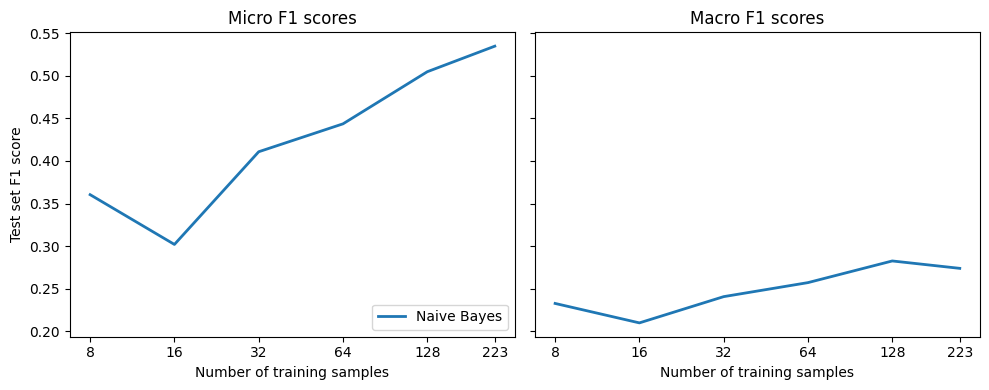

In [39]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label = run , linewidth=2)            
            ax1.plot(sample_sizes, macro_scores[run], label = run , linewidth=2)
        else:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label=run,linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,linestyle="dashed")
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

# Working with no labled data

## Import the pipeline

In [40]:
from transformers import pipeline 
pipe = pipeline("fill-mask", model="bert-base-uncased")
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."
output = pipe(movie_desc + prompt, targets = ['animals', 'car']) 
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Token animals:	0.103%
Token car:	0.000%


In [41]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")


Token cars:	0.139%
Token animals:	0.006%


## Use Multi-Genre NLI Corpus (MNLI) to zero short the model

In [42]:
ds["train"]

Dataset({
    features: ['text', 'labels', 'label_ids'],
    num_rows: 223
})

In [43]:
import torch
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
from transformers import pipeline 
pipe = pipeline("zero-shot-classification", device=device )
sample = ds["train"][0]
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")
for label, score in zip(output["labels"], output["scores"]):
     print(f"{label}, {score:.2f}")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Add new CANINE model +  # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit toke

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.37
usage, 0.30
documentation, 0.26
pytorch, 0.25
model training, 0.24
tokenization, 0.20
pipeline, 0.17


In [45]:
# print pipe arguments
print(pipe.model.config)

BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "contradiction": 0,
    "entailment": 2,
    "neutral": 1
  },
  "max_position_embeddings": 1024,
  "model_type": "bart",
  

In [46]:
def zero_shot_pipeline(example): 
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predictions"] = output["labels"]   
    example["scores"] = output["scores"] 
    return example 
ds_zero_shot = ds["valid"].map(zero_shot_pipeline) 


Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [47]:
def get_preds(example, threshold = None , topk = None ): 
    '''Returns the predicted labels for a given example.'''
    preds = [] 
    if threshold: 
        for label, score in zip(example["predictions"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk: 
        for i in range(topk):
            preds.append(example["predictions"][i]) 
    else: 
        raise ValueError("Either threshold or topk must be set") 
    return {'pred_label_ids': list(np.squeeze(mlb.transform([preds])))}
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"]) 
    return classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
            

## plot top-k pred

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

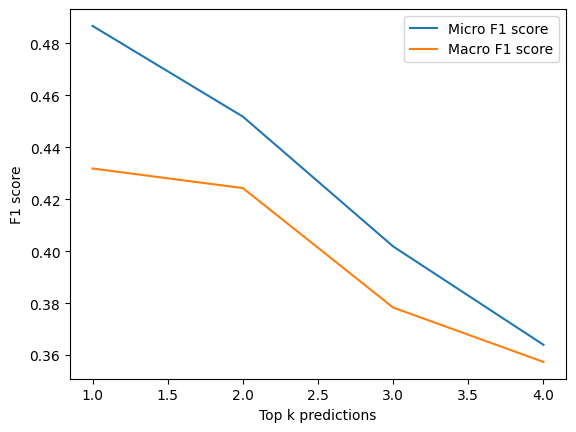

In [48]:
macros , micros = [] , []
topks = [1,2,3,4]
for topk in topks: 
    ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"topk": topk}) 
    clf_report = get_clf_report(ds_zero_shot) 
    macros.append(clf_report["macro avg"]["f1-score"]) 
    micros.append(clf_report["micro avg"]["f1-score"])

plt.plot(topks, micros, label="Micro F1 score")
plt.plot(topks, macros, label="Macro F1 score")
plt.xlabel("Top k predictions")
plt.ylabel("F1 score")
plt.legend(loc = 'best')
plt.show()

## plot threshold pred

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

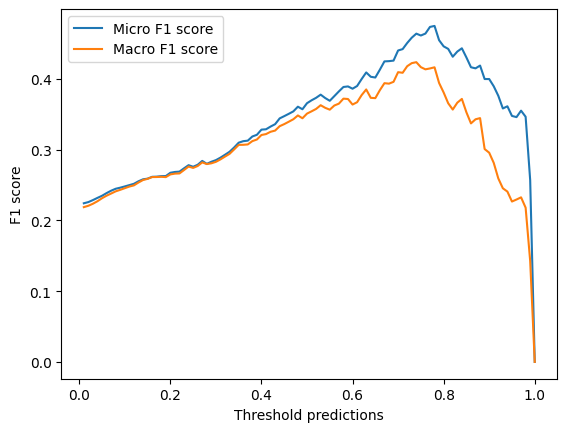

In [49]:
macros , micros = [] , []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds: 
    # dont print progress bar
    ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"threshold": threshold}) 
    clf_report = get_clf_report(ds_zero_shot) 
    macros.append(clf_report["macro avg"]["f1-score"]) 
    micros.append(clf_report["micro avg"]["f1-score"])

plt.plot(thresholds, micros, label="Micro F1 score")
plt.plot(thresholds, macros, label="Macro F1 score")
plt.xlabel("Threshold predictions")
plt.ylabel("F1 score")
plt.legend(loc = 'best')
plt.show()

In [50]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.78 with F1-score 0.48.
Best threshold (micro): 0.74 with F1-score 0.42.


In [51]:
# micro_scores

In [52]:
# macro_scores

In [53]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"topk": 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices: 
    macro_scores["Zero-Shot"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Zero-Shot"].append(clf_report["micro avg"]["f1-score"])


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Naive Bayes
Zero-Shot


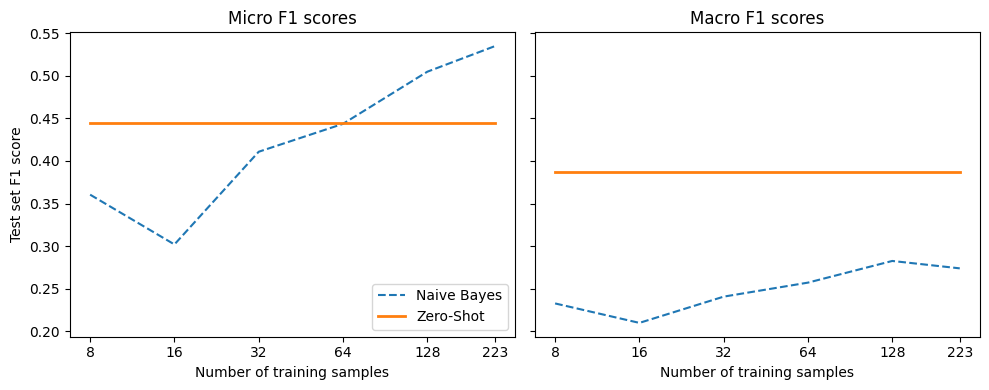

In [54]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero-Shot")


In [55]:
micro_scores.keys()

dict_keys(['Naive Bayes', 'Zero-Shot'])

# Few shot learning

In [56]:
set_seed(3)
aug = naw.ContextualWordEmbsAug(
    model_path = 'distilbert-base-uncased',
    device = device, 
    action = 'substitute' # thay the
)
text = 'Transformers are the most popular toys' 
print(f"Original: {text}") 
print(f"Augmented Text: {aug.augment(text)}") 

Original: Transformers are the most popular toys
Augmented Text: ['transformers produce the most famous toys']


## Augment function

In [58]:
ds_train_sample_copy = ds_train_sample

In [59]:
def augment_text(batch, transformation_per_example = 10): 
    """return augment text and label ids

    Args:
        batch (_type_): batch of data
        transformation_per_example (int, optional):  Defaults to 10.
        more augment data more accuracy
    Returns:
        dict: batch of data augmented
    """
    text_aug , label_ids = [], [] 
    for text, labels in zip(batch['text'], batch['label_ids']): 
        text_aug += [text]
        label_ids += [labels] 
        for _ in range(transformation_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
    return {'text': text_aug, 'label_ids': label_ids}
# test function augment text
batch = {'text': ['Transformers are the most popular toys'], 'label_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
output = augment_text(batch, transformation_per_example=3)
print("output: ", output) 
print("type of output labels_ids: ", type(output['label_ids']))

output:  {'text': ['Transformers are the most popular toys', 'transformers are considered most common toys', 'frogs are the most common toys', 'transformers are generally most common toys'], 'label_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
type of output labels_ids:  <class 'list'>


## Create training set

In [60]:
ds_train_sample_copy = ds_train_sample_copy.map(
    augment_text, 
    batched = True,
    remove_columns= ds_train_sample_copy.column_names,
).shuffle(seed = 42)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

In [61]:
# iter through ds_train_sample_copy
dem = 0
for sample in ds_train_sample_copy:
    print(sample.keys())
    print(sample['text'][:100])
    print(sample['label_ids'][:100])
    dem += 1
    if dem == 2:
        break

dict_keys(['text', 'label_ids'])
exposing prepare _ for _ model for both slow & fast tokenizers + with version v3. 0. 1, two breaking
[0, 0, 0, 0, 0, 0, 0, 1, 0]
dict_keys(['text', 'label_ids'])
new tokenizers issue in ner demo + # [UNK] bug when i use transformers 2. html i get the following e
[0, 0, 0, 0, 0, 0, 0, 1, 0]


## Retrain naive bayes with augment data

In [62]:
ds_train_sample_copy

Dataset({
    features: ['text', 'label_ids'],
    num_rows: 2453
})

In [63]:
ds_train_sample_copy.select([1,2,3])['text']

['new tokenizers issue in ner demo + # [UNK] bug when i use transformers 2. html i get the following error when running the run _ ner demo. it seems to work from when i use 2. 4. i am guessing this is because of a slight difference in the tokenization script? it seems to fail even when running with prefix base german run. sh in the ner / directory. ` ` ` traceback ( most recent call last ) : file " run _ pl _ ner. py ", line 233, in < module > trainer = generic _ train ( model, args ) file " / content / transformers / examples / ner / transformer _ base. py ", line 268, in generic _ train trainer. fit ( model ) file " / usr / local / lib / python3. 6 / dist - packages / pytorch _ lightning / trainer / trainer. py ", line 911, in fit self. single _ gpu _ train ( concept ) file " / usr / local / lib / python3. 6 / dist - packages / pytorch _ lightning / trainer / distrib _ parts. py ", line 464, in single _ gpu _ train self. optimizers, self. lr _ schedulers = self. init _ optimizers ( d

In [64]:
ds_train_sample_copy.select([1,2,3])['label_ids']

[[0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0]]

In [84]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds_train_sample_copy))) , axis=1) 
print(f"Number of samples: {len(all_indices)}")
indices_pool = all_indices 
lables = np.array(ds_train_sample_copy["label_ids"]) 
print("shape of lables: ", lables.shape)
train_samples = [8, 16, 32, 64, 128]
train_samples = [10* i for i in train_samples]
train_slices , last_k = [], 0 
for i , k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
    last_k = k     
    if i == 0:
        train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# add full dataset as last slice 
train_slices.append(all_indices) , train_samples.append(len(ds_train_sample_copy))
train_slices = [np.squeeze(x) for x in train_slices]

Number of samples: 2453
shape of lables:  (2453, 9)


In [66]:
# reset Naive Bayes + Aug
macro_scores["Naive Bayes + Aug"] = []
micro_scores["Naive Bayes + Aug"] = []
for train_slice in train_slices:
    # Get training slice and test data
    # ds_train_sample_copy = ds["train"].select(train_slice)
    ds_train_sample_copy_2 = ds_train_sample_copy.select(train_slice)
    y_train = np.array(ds_train_sample_copy_2["label_ids"])
    y_test_labels = np.array(ds["test"]["label_ids"])
    print(f"Train size: {len(ds_train_sample_copy_2)}")

    # Use a simple count vectorizer to encode our texts as token counts
    count_vectorize = CountVectorizer()
    X_train_counts = count_vectorize.fit_transform(ds_train_sample_copy_2["text"])

    X_test_counts = count_vectorize.transform(ds["test"]["text"])

    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    print("Training done!")
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
            y_test_labels, y_pred_test, target_names=mlb.classes_, zero_division=0,
            output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Train size: 82
Training done!
Train size: 164
Training done!
Train size: 323
Training done!
Train size: 641
Training done!
Train size: 1279
Training done!
Train size: 2453
Training done!


## Plot the metrics

In [67]:
macro_scores

defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086],
             'Zero-Shot': [0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515],
             'Naive Bayes + Aug': [0.27235449735449735,
              0.278589655958077,
              0.33758862806420187,
              0.4415159953502743,
              0.4563280715286368,
              0.4832651770367019]})

In [68]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347],
             'Zero-Shot': [0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445],
             'Naive Bayes + Aug': [0.5081081081081081,
              0.4954128440366973,
              0.5084745762711865,
              0.5679012345679012,
              0.5590551181102362,
              0.578125]})

Naive Bayes
Zero-Shot
Naive Bayes + Aug


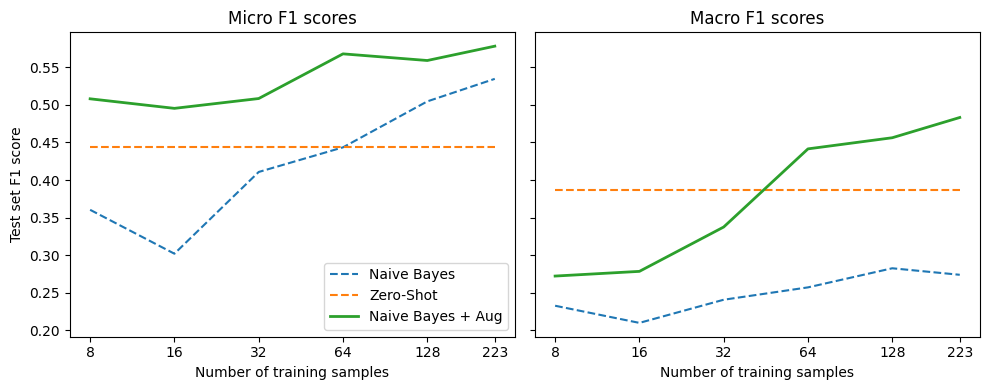

In [69]:
train_samples = [8, 16, 32, 64, 128, 223]
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

# Fine tune with augment data

## init macros and micros score 

In [71]:
macro_scores = defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086],
             'Zero-Shot': [0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515],
             'Naive Bayes + Aug': [0.27235449735449735,
              0.278589655958077,
              0.33758862806420187,
              0.4415159953502743,
              0.4563280715286368,
              0.4832651770367019],
             'Embedding GPT2': [0.2359519022412816,
              0.22399328684158407,
              0.24991158684522524,
              0.3304358431861561,
              0.31501683091623417,
              0.30677622391019166],
             'Fine-tune (vanilla)': [0.059770114942528735,
              0.1645095645095645,
              0.2286324786324786,
              0.40153390305682585,
              0.5840550899061536,
              0.6127081681040847]})
micro_scores = defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347],
             'Zero-Shot': [0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445],
             'Naive Bayes + Aug': [0.5081081081081081,
              0.4954128440366973,
              0.5084745762711865,
              0.5679012345679012,
              0.5590551181102362,
              0.578125],
             'Embedding GPT2': [0.3167155425219942,
              0.36363636363636365,
              0.39452054794520547,
              0.5118483412322274,
              0.46564885496183206,
              0.5402843601895735],
             'Fine-tune (vanilla)': [0.07633587786259542,
              0.3006535947712418,
              0.5104166666666667,
              0.58,
              0.6486486486486487,
              0.6949152542372881]})

In [72]:
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

## Load the base model


In [85]:
ds_train_sample_copy

Dataset({
    features: ['text', 'label_ids'],
    num_rows: 2453
})

In [86]:
model_ckpt  = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True) 
ds_enc = ds_enc.remove_columns(["text", "labels"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [90]:
ds_augment = ds_train_sample_copy.map(tokenize, batched=True)
ds_augment = ds_augment.remove_columns(["text"])

Map:   0%|          | 0/2453 [00:00<?, ? examples/s]

In [91]:
ds_augment

Dataset({
    features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2453
})

In [92]:
ds_enc['train'] = ds_augment

In [93]:
ds_enc

DatasetDict({
    train: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2453
    })
    valid: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 106
    })
    test: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9303
    })
})

In [97]:
ds_enc.set_format("torch") 
ds_enc = ds_enc.map(lambda x: {'label_ids_f': x['label_ids'].to(torch.float)},
                               remove_columns = ["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/2453 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

## Training config


In [98]:
ds_enc = ds_enc.shuffle(seed = 42)

In [99]:

training_args_fine_tune = TrainingArguments(
 output_dir="./results", num_train_epochs=20, learning_rate=7e-5,
 lr_scheduler_type='constant', per_device_train_batch_size=4,
 per_device_eval_batch_size=256, weight_decay=0.0,
 evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
 load_best_model_at_end=True, metric_for_best_model='micro f1',
 save_total_limit=1, log_level='error')
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
    zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
    "macro f1": clf_dict["macro avg"]["f1-score"]}

In [100]:
for i in train_slices:
    print(len(i))

82
164
323
641
1279
2453


## Train model

In [101]:
## Train the model through training slices
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
    config=config)
    trainer = Trainer(
    model=model, tokenizer=tokenizer,
    args=training_args_fine_tune,
    compute_metrics=compute_metrics,
    train_dataset=ds_enc["train"].select(train_slice),
    eval_dataset=ds_enc["valid"],)
    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla) + Aug"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla) + Aug"].append(metrics["micro f1"])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4655, 'learning_rate': 7e-05, 'epoch': 1.0}
{'eval_loss': 0.37670284509658813, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1556, 'eval_samples_per_second': 681.318, 'eval_steps_per_second': 6.428, 'epoch': 1.0}
{'loss': 0.3421, 'learning_rate': 7e-05, 'epoch': 2.0}
{'eval_loss': 0.35356849431991577, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1551, 'eval_samples_per_second': 683.491, 'eval_steps_per_second': 6.448, 'epoch': 2.0}
{'loss': 0.3106, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.3227217197418213, 'eval_micro f1': 0.2857142857142857, 'eval_macro f1': 0.09150326797385622, 'eval_runtime': 0.1566, 'eval_samples_per_second': 676.968, 'eval_steps_per_second': 6.386, 'epoch': 3.0}
{'loss': 0.283, 'learning_rate': 7e-05, 'epoch': 4.0}
{'eval_loss': 0.3226580023765564, 'eval_micro f1': 0.4292237442922374, 'eval_macro f1': 0.1553857100231816, 'eval_runtime': 0.1551, 'eval_samples_per_second': 683.609, 'eval_steps_per_second': 6.4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.3951, 'learning_rate': 7e-05, 'epoch': 1.0}
{'eval_loss': 0.3537552058696747, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1556, 'eval_samples_per_second': 681.292, 'eval_steps_per_second': 6.427, 'epoch': 1.0}
{'loss': 0.3141, 'learning_rate': 7e-05, 'epoch': 2.0}
{'eval_loss': 0.3047599196434021, 'eval_micro f1': 0.3401360544217687, 'eval_macro f1': 0.1313405797101449, 'eval_runtime': 0.1563, 'eval_samples_per_second': 678.299, 'eval_steps_per_second': 6.399, 'epoch': 2.0}
{'loss': 0.2615, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.30258646607398987, 'eval_micro f1': 0.3401360544217687, 'eval_macro f1': 0.127964615267292, 'eval_runtime': 0.1558, 'eval_samples_per_second': 680.326, 'eval_steps_per_second': 6.418, 'epoch': 3.0}
{'loss': 0.2293, 'learning_rate': 7e-05, 'epoch': 4.0}
{'eval_loss': 0.2670714855194092, 'eval_micro f1': 0.4799999999999999, 'eval_macro f1': 0.2371504157218443, 'eval_runtime': 0.1551, 'eval_samples_per_second': 683.272, 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.3673, 'learning_rate': 7e-05, 'epoch': 1.0}
{'eval_loss': 0.32538101077079773, 'eval_micro f1': 0.2446043165467626, 'eval_macro f1': 0.08785529715762273, 'eval_runtime': 0.1578, 'eval_samples_per_second': 671.746, 'eval_steps_per_second': 6.337, 'epoch': 1.0}
{'loss': 0.2695, 'learning_rate': 7e-05, 'epoch': 2.0}
{'eval_loss': 0.27484631538391113, 'eval_micro f1': 0.5056179775280898, 'eval_macro f1': 0.24073659418487006, 'eval_runtime': 0.1583, 'eval_samples_per_second': 669.442, 'eval_steps_per_second': 6.315, 'epoch': 2.0}
{'loss': 0.1899, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.2289135456085205, 'eval_micro f1': 0.5882352941176471, 'eval_macro f1': 0.3460440268950908, 'eval_runtime': 0.1605, 'eval_samples_per_second': 660.42, 'eval_steps_per_second': 6.23, 'epoch': 3.0}
{'loss': 0.1299, 'learning_rate': 7e-05, 'epoch': 4.0}
{'eval_loss': 0.22962135076522827, 'eval_micro f1': 0.6, 'eval_macro f1': 0.3983872513284277, 'eval_runtime': 0.1572, 'eval_samples_per_

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.335, 'learning_rate': 7e-05, 'epoch': 1.0}
{'eval_loss': 0.29244565963745117, 'eval_micro f1': 0.29577464788732394, 'eval_macro f1': 0.10144927536231883, 'eval_runtime': 0.1591, 'eval_samples_per_second': 666.07, 'eval_steps_per_second': 6.284, 'epoch': 1.0}
{'loss': 0.211, 'learning_rate': 7e-05, 'epoch': 2.0}
{'eval_loss': 0.23455506563186646, 'eval_micro f1': 0.5961538461538463, 'eval_macro f1': 0.4229304456440889, 'eval_runtime': 0.1587, 'eval_samples_per_second': 667.768, 'eval_steps_per_second': 6.3, 'epoch': 2.0}
{'loss': 0.125, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.26951736211776733, 'eval_micro f1': 0.6074766355140186, 'eval_macro f1': 0.416120541899142, 'eval_runtime': 0.1591, 'eval_samples_per_second': 666.264, 'eval_steps_per_second': 6.286, 'epoch': 3.0}
{'loss': 0.0729, 'learning_rate': 7e-05, 'epoch': 4.0}
{'eval_loss': 0.2174108326435089, 'eval_micro f1': 0.676056338028169, 'eval_macro f1': 0.6112209618917566, 'eval_runtime': 0.1585, 'eval_sam

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.2647, 'learning_rate': 7e-05, 'epoch': 1.0}
{'eval_loss': 0.28209832310676575, 'eval_micro f1': 0.5056179775280898, 'eval_macro f1': 0.3020567801269556, 'eval_runtime': 0.1587, 'eval_samples_per_second': 668.01, 'eval_steps_per_second': 6.302, 'epoch': 1.0}
{'loss': 0.0888, 'learning_rate': 7e-05, 'epoch': 2.0}
{'eval_loss': 0.24599404633045197, 'eval_micro f1': 0.6905829596412557, 'eval_macro f1': 0.6302817584360636, 'eval_runtime': 0.1612, 'eval_samples_per_second': 657.524, 'eval_steps_per_second': 6.203, 'epoch': 2.0}
{'loss': 0.0309, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.2232477366924286, 'eval_micro f1': 0.7657657657657657, 'eval_macro f1': 0.7166670509015733, 'eval_runtime': 0.1597, 'eval_samples_per_second': 663.583, 'eval_steps_per_second': 6.26, 'epoch': 3.0}
{'loss': 0.0183, 'learning_rate': 7e-05, 'epoch': 4.0}
{'eval_loss': 0.2435903698205948, 'eval_micro f1': 0.7659574468085107, 'eval_macro f1': 0.7314864329570212, 'eval_runtime': 0.1608, 'eval_

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.1955, 'learning_rate': 7e-05, 'epoch': 1.0}
{'eval_loss': 0.2283172458410263, 'eval_micro f1': 0.7255813953488371, 'eval_macro f1': 0.6380827133700697, 'eval_runtime': 0.1615, 'eval_samples_per_second': 656.446, 'eval_steps_per_second': 6.193, 'epoch': 1.0}
{'loss': 0.0347, 'learning_rate': 7e-05, 'epoch': 2.0}
{'eval_loss': 0.2832457721233368, 'eval_micro f1': 0.6995515695067265, 'eval_macro f1': 0.6092696365171393, 'eval_runtime': 0.1608, 'eval_samples_per_second': 659.223, 'eval_steps_per_second': 6.219, 'epoch': 2.0}
{'loss': 0.0067, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.30614209175109863, 'eval_micro f1': 0.6926406926406925, 'eval_macro f1': 0.5884608335631052, 'eval_runtime': 0.1621, 'eval_samples_per_second': 653.774, 'eval_steps_per_second': 6.168, 'epoch': 3.0}
{'loss': 0.0037, 'learning_rate': 7e-05, 'epoch': 4.0}
{'eval_loss': 0.36556926369667053, 'eval_micro f1': 0.7048458149779735, 'eval_macro f1': 0.6192634363686994, 'eval_runtime': 0.1622, 'eva

In [104]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347],
             'Zero-Shot': [0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445],
             'Naive Bayes + Aug': [0.5081081081081081,
              0.4954128440366973,
              0.5084745762711865,
              0.5679012345679012,
              0.5590551181102362,
              0.578125],
             'Embedding GPT2': [0.3167155425219942,
              0.36363636363636365,
              0.39452054794520547,
              0.5118483412322274,
              0.46564885496183206,
              0.5402843601895735],
             'Fine-tune (vanilla)': [0.07633587786259542,
              0.3006535947712418,
        

Naive Bayes
Zero-Shot
Naive Bayes + Aug
Embedding GPT2
Fine-tune (vanilla)
Fine-tune (vanilla) + Aug


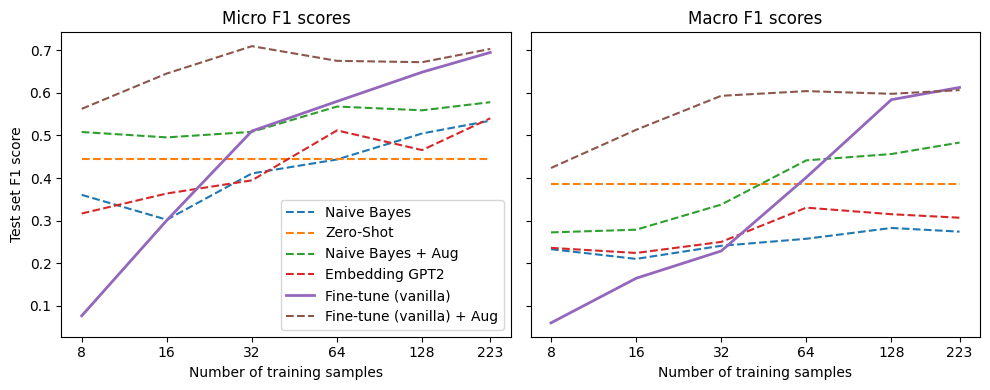

In [111]:
train_samples = [8, 16, 32, 64, 128, 223]
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

## save results

In [ ]:
micro_scores = defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347],
             'Zero-Shot': [0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445],
             'Naive Bayes + Aug': [0.5081081081081081,
              0.4954128440366973,
              0.5084745762711865,
              0.5679012345679012,
              0.5590551181102362,
              0.578125],
             'Embedding GPT2': [0.3167155425219942,
              0.36363636363636365,
              0.39452054794520547,
              0.5118483412322274,
              0.46564885496183206,
              0.5402843601895735],
             'Fine-tune (vanilla)': [0.07633587786259542,
              0.3006535947712418,
              0.5104166666666667,
              0.58,
              0.6486486486486487,
              0.6949152542372881,],
             'Fine-tune (vanilla) + Aug': [0.5625,
              0.6454545454545455,
              0.7096774193548387,
              0.6752136752136751,
              0.6720647773279351,
              0.7031963470319634]})
macro_scores = defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086],
             'Zero-Shot': [0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515],
             'Naive Bayes + Aug': [0.27235449735449735,
              0.278589655958077,
              0.33758862806420187,
              0.4415159953502743,
              0.4563280715286368,
              0.4832651770367019],
             'Embedding GPT2': [0.2359519022412816,
              0.22399328684158407,
              0.24991158684522524,
              0.3304358431861561,
              0.31501683091623417,
              0.30677622391019166],
             'Fine-tune (vanilla)': [0.059770114942528735,
              0.1645095645095645,
              0.2286324786324786,
              0.40153390305682585,
              0.5840550899061536,
              0.6127081681040847,], 
             'Fine-tune (vanilla) + Aug': [              0.42355811829496043,
              0.5132509044178506,
              0.5930741709345828,
              0.6041033085580728,
              0.5977837061033886,
              0.606465900200236]})